# Assignment 2:  YINGWEI CHEN


# Question 1
Get 1-day trading data (open, close, high, low and volume) with 1 minute intveral for Therma Bright Inc. (THRM.V).
Plot candle stick plot and VWAP in one figure using the 1-day data above. 

In [110]:
import finnhub
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import plotly.graph_objects as go

stock_name='THRM.V'
#stock_name='AMZN'
stock_candle=yf.Ticker(stock_name).history(interval='1m', period='1d')
stock_candle=stock_candle.reset_index()
stock_candle['trading_date']=stock_candle['Datetime'].apply(lambda x: x.date())
stock_candle['trading_time']=stock_candle['Datetime'].apply(lambda x: x.time().strftime('%H:%M'))
stock_candle['volume_cumsum']=stock_candle['Volume'].cumsum()

range_high=stock_candle['High'].max()*1.01
range_low=stock_candle['Low'].min()*0.99

price_list=['Open','High','Low','Close']
price_vwap=['VWAP_'+x for x in price_list]
for price_type, price_vwap in zip(price_list,price_vwap):
    stock_candle[price_vwap]=(stock_candle[price_type]*stock_candle['Volume']).cumsum()/stock_candle['volume_cumsum']

raw_trading_data=go.Candlestick(x=stock_candle['trading_time'], open=stock_candle['Open'], high=stock_candle['High'], low=stock_candle['Low'], close=stock_candle['Close'])
vwap_trading_data=go.Scatter(x=stock_candle['trading_time'], y=stock_candle['VWAP_Close'])

fig=go.Figure(data=[raw_trading_data,vwap_trading_data])
fig.update_layout(title=f'Stock Candle and VWAP ---- {stock_name} ---- Intraday ', title_font_size=30, showlegend=True, 
                  width=1200, height=600, yaxis_title=f'Stock Price', xaxis_title=f'Trading Time')

fig.update_yaxes(range=(range_low,range_high))
fig.show()

# Question 2
Get daily trading data (pen, close, high, low and volume) from 20180-01-01 to 2020-12-31 for Therma Bright Inc. (THRM.V)
Plot candle stick plot and 30-day and 100 day expenential moving averages on one figure. 

In [111]:
stock_name='THRM.V'
hist_2018_2020=yf.download(stock_name, start='2018-01-01', end='2021-01-01' ).reset_index()
alpha_30=2.0/(30+1)
alpha_100=2.0/(100+1) 
hist_2018_2020.loc[:,'sma_30'] =hist_2018_2020['Close'].rolling(30).mean()
hist_2018_2020.loc[:,'sma_100']=hist_2018_2020['Close'].rolling(100).mean()

# Comment out 2 lines code are not correct and keep here for reference 
#hist_2018_2020['EMA_30']=np.where(hist_2018_2020['EMA_30'].shift(periods=1)>0, 
#    alpha_30*hist_2018_2020['Close']+hist_2018_2020['EMA_30'].shift(periods=1)*(1-alpha_30), hist_2018_2020['EMA_30']) 

def ema_from_df(array_df, ema_cnt):
    alpha=2.0/(1+ema_cnt)
    if len(array_df)<=ema_cnt:
        print(f"The input columns is shorter than {ema_cnt}")
    else:
        array_size=array_df.size
        temp_arr=np.zeros(array_size)
        copy_arr=np.copy(array_df)
        temp_arr[ema_cnt-1]=copy_arr[:ema_cnt].mean()
        print( temp_arr[ema_cnt-1])
        for i in range(ema_cnt, array_size):
            temp_arr[i]=temp_arr[i-1]*(1-alpha)+copy_arr[i]*alpha
        return temp_arr

hist_2018_2020.loc[:,'ema_30']=ema_from_df(hist_2018_2020['Close'], 30)
hist_2018_2020.loc[:,'ema_100']=ema_from_df(hist_2018_2020['Close'], 100)

daily_trading_data=go.Candlestick(x=hist_2018_2020['Date'], open=hist_2018_2020['Open'], high=hist_2018_2020['High'], 
                                  low=hist_2018_2020['Low'], close=hist_2018_2020['Close'])
ema30_trading_data=go.Scatter(x=hist_2018_2020['Date'], y=hist_2018_2020['ema_30'])
ema100_trading_data=go.Scatter(x=hist_2018_2020['Date'], y=hist_2018_2020['ema_100'])

fig=go.Figure(data=[daily_trading_data,ema30_trading_data, ema100_trading_data])
fig.update_layout(title=f'{stock_name} Stock Candle and EMA 30 & 100', title_font_size=30, showlegend=True, 
                  width=1200, height=600, xaxis_title='Trading Date', yaxis_title=f'{stock_name} Stock')

fig.show()

[*********************100%***********************]  1 of 1 completed
0.0851666676501433
0.06315000016242266


# Question 3: (1)
Use the same data in Question 2.
    (1) Calculate daily return (return=log(today close/previous close)

In [112]:
hist_2018_2020.loc[:,'daily_return']=np.log(hist_2018_2020['Close']/hist_2018_2020['Close'].shift(periods=1))
hist_2018_2020=hist_2018_2020[hist_2018_2020['daily_return'].notnull()]
hist_2018_2020[['Close','daily_return']]

,Close,daily_return
1,0.075,0.000000
2,0.070,-0.068993
3,0.065,-0.074108
4,0.080,0.207639
5,0.100,0.223144
...,...,...
748,0.210,-0.023531
749,0.225,0.068993
750,0.225,0.000000
751,0.225,0.000000


# Question 3: (2)
Use the same data in Question 2.
    (2) Conduct the hypothesis testing to check if the distribution of daily return is normal

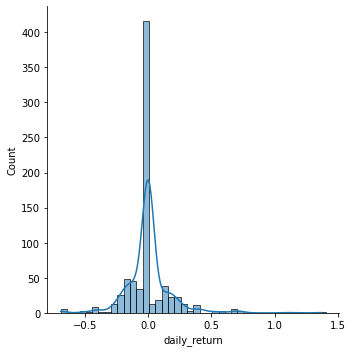

In [113]:
# Visualization can provide the first impresssion of statistic distribution
import seaborn as sns
from scipy import stats 
sns.displot(hist_2018_2020['daily_return'],kde=True, binwidth=0.05)

In [114]:
# Calculate the sample mean and standard error
# Make assumption of using sample mean and standard error as the mean and stardard deviation of normal distribution.
# Print out H0 and H1 content

from scipy import stats 
hist_2018_2020.columns
#print(hist_2018_2020.head())
sample_mean=hist_2018_2020['daily_return'].mean()
sample_std=hist_2018_2020['daily_return'].std()
print("-------------------------------------------------------------------------------------------")
print(f"The sample Mean: {sample_mean} \nThe sample standard deviation: {sample_std} \n")
print(f"Assume the sample mean and standard error are the best estimate of population mean and standard deviation")
print("We make Hypothesis H0 and H1 as follow:")
print(f"H0: the stock daily return follow normal distribution of N({sample_mean},{sample_std})")
print(f"H1: the stock daily return does not follow normal distribution")

-------------------------------------------------------------------------------------------
The sample Mean: 0.001400465281235082 
The sample standard deviation: 0.17459207289146936 

Assume the sample mean and standard error are the best estimate of population mean and standard deviation
We make Hypothesis H0 and H1 as follow:
H0: the stock daily return follow normal distribution of N(0.001400465281235082,0.17459207289146936)
H1: the stock daily return does not follow normal distribution


In [115]:
# There are multiple testing methodologies avaialbe in Python Scipy package 
# Kolmogorov-Smirnov test is presented as follow

stats_ks, pvalue_ks=stats.kstest(hist_2018_2020['daily_return'],'norm',(sample_mean,sample_std))
print(f"KS test result: \n *** Test Statistic: {stats_ks} *** P-Value: {pvalue_ks} \n")
print ("Conclusion: (when set critical value as 0.05)")
if pvalue_ks<0.05:
    print(f"The pvalue of KS test is {pvalue_ks} and less than 0.05, We REJECT H0 and conclude that daily return does NOT folow normal distribution!")
else:
   print(f"The pvalue of KS test is {pvalue_ks} and large than 0.05, We ACCEPT H0 and conclude that daily return folow normal distribution!" ) 

KS test result: 
 *** Test Statistic: 0.29841278994676507 *** P-Value: 7.165538917336539e-60 

Conclusion: (when set critical value as 0.05)
The pvalue of KS test is 7.165538917336539e-60 and less than 0.05, We REJECT H0 and conclude that daily return does NOT folow normal distribution!


# Question 4

Take 10 stocks in S&P 500 and collect daily close price from 2020-06-01 to 2020-12-31 for slected stocks
(1) Calculate daily return for each of 10 stocks.

In [116]:
df_sp500=pd.read_csv(r"C:\Finnhub_Data\finnhub_data\S_P550_Symbol_list.csv")
#yf_stock=yf.download(sp500_10, start='2020-06-01', end='2020-12-31')
stock_list=list(df_sp500.loc[:9,'Symbol'])
stock_daily=[]
for stock_name in stock_list:
    yf_stock=yf.download(stock_name,  start='2020-06-01', end='2020-12-31')
    yf_stock['symbol']=stock_name
    yf_stock[f'return_{stock_name}']=np.log(yf_stock['Close']/yf_stock['Close'].shift(periods=1))
    stock_daily.append(yf_stock.loc[:,[f'return_{stock_name}']])
    
stock_10sp=pd.concat(stock_daily,axis=1)
print(stock_10sp)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
            return_MMM  return_ABT  return_ABBV  return_ABMD  return_ACN  \
Date                                                                       
2020-06-01         NaN         NaN          NaN          NaN         NaN   
2020-06-02    0.013154   -0.004202     0.003742     0.019791    0.011731   
2020-0

# Question 4 - (2)
Run PCA on calculated daily return and find the first principal component.

In [117]:
# Method 1: Self-Implementation Notice: set STD(ddof=0) is to be consistent with the PYTHON preprocessing package. ddof=1 is default could make more sense here.   

stock_10sp=stock_10sp[stock_10sp.index>'2020-06-01']
print(len(stock_10sp))
#adjust_std=np.sqrt(len(stock_10sp)/(len(stock_10sp)-1))  
#print(adjust_std)
for stock_name in stock_list:
    stock_10sp[f'return_{stock_name}_u']=stock_10sp[f'return_{stock_name}'].mean()
    stock_10sp[f'return_{stock_name}_s']=stock_10sp[f'return_{stock_name}'].std()
    stock_10sp[f'return_{stock_name}_standard']=(stock_10sp[f'return_{stock_name}']-stock_10sp[f'return_{stock_name}_u'])/stock_10sp[f'return_{stock_name}'].std(ddof=0)
    #stock_10sp[f'return_{stock_name}_standard']=stock_10sp[f'return_{stock_name}_standard']*adjust_std
col_return_standard=[f'return_{x}_standard' for x in stock_list]
self_preprocessing_df=stock_10sp[col_return_standard]
print(self_preprocessing_df)

148
            return_MMM_standard  return_ABT_standard  return_ABBV_standard  \
Date                                                                         
2020-06-02             0.796493            -0.314648              0.179834   
2020-06-03             1.390323            -0.858644             -0.174605   
2020-06-04             0.483121            -2.168655              1.471036   
2020-06-05             1.844451             1.023528              0.503759   
2020-06-08            -0.256501             1.715702              0.450222   
...                         ...                  ...                   ...   
2020-12-23            -0.340003            -0.524430              0.240107   
2020-12-24             0.146605             0.438671             -0.078914   
2020-12-28             0.021067            -0.373500              0.054686   
2020-12-29            -0.365994             0.237842              0.723529   
2020-12-30             0.047177            -0.001333        

In [118]:
#Method 2 Standardize return using Python preprocessing package
# For demonstration purpose only
from sklearn.preprocessing import StandardScaler
raw_feature=['return_'+x for x in stock_list]
sklearn_preprocessing=stock_10sp.loc[:,raw_feature]
#print(sklearn_preprocessing)
sklearn_preprocessing=StandardScaler().fit_transform(sklearn_preprocessing)
sklearn_preprocessing_df=pd.DataFrame(sklearn_preprocessing)
sklearn_preprocessing_df.columns=col_return_standard
#print(sklearn_preprocessing_df)

In [119]:
# Princial Component Analysis on Standardized Data
# Merge back with standardized return columns
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
principal_components=pca.fit_transform(self_preprocessing_df)
PCA_Final_df=pd.concat([pd.DataFrame(principal_components,columns=['Return_Close_PCA1','Return_Close_PCA2']),
                        self_preprocessing_df.reset_index()],axis=1).set_index('Date')
print(PCA_Final_df)

            Return_Close_PCA1  Return_Close_PCA2  return_MMM_standard  \
Date                                                                    
2020-06-02          -0.939493          -1.233198             0.796493   
2020-06-03          -0.385581          -3.067722             1.390323   
2020-06-04           1.089927          -0.831744             0.483121   
2020-06-05          -3.356692          -1.840471             1.844451   
2020-06-08          -1.973215          -0.220244            -0.256501   
...                       ...                ...                  ...   
2020-12-23           0.447512          -0.589730            -0.340003   
2020-12-24          -0.239738           0.307374             0.146605   
2020-12-28          -0.153035           0.190966             0.021067   
2020-12-29           0.072545           0.307427            -0.365994   
2020-12-30           0.090792           0.394585             0.047177   

            return_ABT_standard  return_ABBV_stand

# Question 4 (3)  Note: Using Two Y-axis to handle different scale
Plot first principal compoent and daily return of S&P500 in one figure

[*********************100%***********************]  1 of 1 completed
          Date  sp500_return_pct  sp500_return  Return_Close_PCA1
0   2020-06-02          0.817731      0.008177          -0.939493
1   2020-06-03          1.355667      0.013557          -0.385581
2   2020-06-04         -0.337439     -0.003374           1.089927
3   2020-06-05          2.587401      0.025874          -3.356692
4   2020-06-08          1.196966      0.011970          -1.973215
..         ...               ...           ...                ...
143 2020-12-23          0.074553      0.000746           0.447512
144 2020-12-24          0.353035      0.003530          -0.239738
145 2020-12-28          0.868471      0.008685          -0.153035
146 2020-12-29         -0.222986     -0.002230           0.072545
147 2020-12-30          0.134065      0.001341           0.090792

[148 rows x 4 columns]


Text(0.5, 1.0, 'PCA of 10 Stock vs. SP500 Index Daily Return - Using 2 Axis')

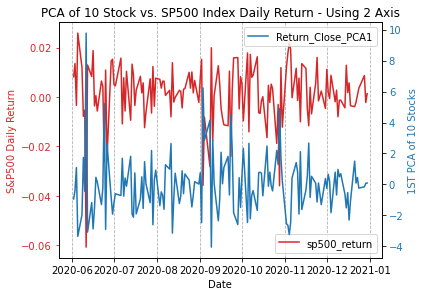

In [120]:
sp500=yf.download('^GSPC',  start='2020-06-01', end='2020-12-31')
sp500['sp500_return']=np.log(sp500['Close']/sp500['Close'].shift(periods=1))
sp500['sp500_return_pct']=sp500['sp500_return']*100
sp500_pca=pd.concat([sp500.loc[sp500.index>'2020-06-01',['sp500_return_pct','sp500_return']],PCA_Final_df.loc[:,'Return_Close_PCA1'] ], axis=1).reset_index()
print(sp500_pca)

import matplotlib.pyplot as plt
fig,ax1=plt.subplots()
color_ax1='tab:red'
color_ax2='tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('S&P500 Daily Return', color=color_ax1)
ax1.plot('Date', 'sp500_return', data=sp500_pca,color=color_ax1)
ax1.tick_params(axis='y',color='red',labelcolor=color_ax1)
plt.legend()
ax2=ax1.twinx()
ax2.set_ylabel('1ST PCA of 10 Stocks',color=color_ax2)
ax2.plot('Date', 'Return_Close_PCA1',data=sp500_pca, color=color_ax2)
ax2.tick_params(axis='y',labelcolor=color_ax2)
fig.tight_layout()
#plt.plot('Date', 'sp500_return_pct', data=sp500_pca)
#plt.plot('Date', 'Return_Close_PCA1',data=sp500_pca)

ax1.xaxis.grid(which='major',linestyle='--')
plt.legend()
plt.title("PCA of 10 Stock vs. SP500 Index Daily Return - Using 2 Axis")


# Question 4 (4) 
Calculate the correlation coefficient between first principal component and daily return of S&P500 index

In [125]:
from scipy.stats import pearsonr
corr,pvalue=pearsonr(sp500_pca['sp500_return'],sp500_pca['Return_Close_PCA1'])
print('------------------------------------------------------------------------------------')
print(f"The correlation Coefficient is: {corr} and pvalue is: {pvalue}")
print('------------------------------------------------------------------------------------')
significant_level=0.05
corr_threshold=0.5
if pvalue<significant_level:
    if corr>corr_threshold:
        print(f"Conclusion:The 1st PCA of selected 10 Stocks and SP500 Index Daily Return are positive correlated when threshold set as {corr_threshold} and significant level {significant_level}!")
    if corr<corr_threshold*(-1):
        print(f"Conclusion:The 1st PCA of selected 10 stocks and SP500 Index Daily Return are negative correlated when threshold set as {corr_threshold} and significant level {significant_level}!")
print('------------------------------------------------------------------------------------')

------------------------------------------------------------------------------------
The correlation Coefficient is: -0.8835144305792828 and pvalue is: 6.061556245048064e-50
------------------------------------------------------------------------------------
Conclusion:The 1st PCA of selected 10 stocks and SP500 Index Daily Return are negative correlated when threshold set as 0.5 and significant level 0.05!
------------------------------------------------------------------------------------


# Extra Credit
Pick 2 companies in the same indsutry, collect close, open, high and low for each company from 2020-06 to 202012.
Variable set 1 - company A's close, open, high and low
Variable set 2 - company B's close, open, high and low
(1) Run canonical analysis using data stated above
(2) Give some conclusion or finding from your analysis

In [126]:
# (1) Frun canonical analysis using data stated above
from sklearn.cross_decomposition import CCA
stock_symbol1='DAL'
stock_symbol2='UAL'
stock_same_industry=[stock_symbol1,stock_symbol2]
stock_df=['stock_'+x for x in stock_same_industry]
start_date='2020-06-01'
end_date='2020-12-31'
stock_1=yf.download(stock_symbol1,'2020-06-01','2020-12-31')
stock_2=yf.download(stock_symbol2,'2020-06-01','2020-12-31')
column_keep=['Open','High','Low','Close']
stock_1=stock_1[column_keep]
stock_2=stock_2[column_keep]
stock_1=(stock_1-stock_1.mean())/stock_1.std()
stock_2=(stock_2-stock_2.mean())/stock_2.std()
print(stock_1)
ca=CCA()
ca.fit(stock_1, stock_2)
stock1_cca, stock2_cca=ca.transform(stock_1, stock_2)
corr_first=np.corrcoef(stock1_cca[:,0],stock2_cca[:,0])
corr_second=np.corrcoef(stock1_cca[:,1],stock2_cca[:,1])
print(f"The correlation between first components of two CCA is {corr_first[0,1]}")
print(f"The correlation between second components of two CCA is {corr_second[0,1]}")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                Open      High       Low     Close
Date                                              
2020-06-01 -1.348561 -1.212318 -1.281585 -1.200969
2020-06-02 -1.081040 -1.168388 -1.107746 -1.152838
2020-06-03 -1.015646 -0.844901 -0.954121 -0.739716
2020-06-04 -0.369634 -0.004235 -0.444732  0.044416
2020-06-05  1.003637  0.880362  0.410314  0.401386
...              ...       ...       ...       ...
2020-12-23  1.419779  1.525338  1.568567  1.620701
2020-12-24  1.641722  1.519347  1.653465  1.518423
2020-12-28  1.611998  1.587240  1.736342  1.602652
2020-12-29  1.724951  1.599221  1.714107  1.578586
2020-12-30  1.558494  1.613199  1.712086  1.684876

[149 rows x 4 columns]
The correlation between first components of two CCA is 0.9623537744088362
The correlation between second components of two CCA is 0.9063151681785587


#(2) Give some conclusion or findings from your analysis
Conclusion:
    UAL and DAL are two companies in the Airlines industry which were highly negative 
    affected by the covid-19 and positively affected by government support and vaccine information.
    The volatility from above reason would dominate over other factors such as financial performance during
    this special periods. Thus it is not surprise to see the first component show high correlation of 0.96.
    Since our attributes are limited to stock prices (Open, High,Low,Close) thus the variability among attributes 
    are very limit. This leads to the unusually high correlation coefficience of the second components. 
    Following heatmap shows the correlation matrix of stock prices (Open, High, Low, Close) using stock 1 (DAL) as example. 
    

<AxesSubplot:>

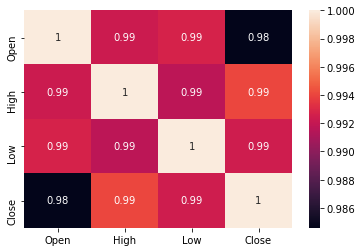

In [109]:
correlation_matrix=stock_1.corr()
sns.heatmap(correlation_matrix, annot=True)